In [1]:
"""
ISC with sliding window to capture variations in relationship between ISC and emotional report
"""

import os
import pickle
from concurrent.futures import ThreadPoolExecutor, as_completed
import cProfile
import time
from glob import glob
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from isc_standalone import p_from_null, isc, load_boolean_mask
from ISC_Helper import get_rois, _compute_phaseshift_sliding_isc, load_roi_data
import nibabel as nib
from nilearn import plotting

# -------------------------------
# Parameters
# -------------------------------
task = 'onesmallstep'
roi_selected = ['wholebrain']
# roi_selected = ['PCC', 'ACC']
emotions = ['P', 'N', 'M', 'X', 'Cry']  # Positive, Negative, Mixed, Neutral
avg_over_roi = True
spatial = False
pairwise = False
random_state = None
window_size = 30
step_size = 5
if task == 'toystory':
    n_trs = 274
    n_shifts = 10000
elif task == 'onesmallstep':
    n_trs = 454
    n_shifts = 10000
else:
    raise Exception('task not defined')
n_windows = int((n_trs - window_size) / step_size) + 1
batch_size = 16

smooth = 'smooth'
avg_over_roi_name = "avg" if avg_over_roi else "voxelwise"
spatial_name = "spatial" if spatial else "temporal"
pairwise_name = "pairwise" if pairwise else "group"

# -------------------------------
# File paths
# -------------------------------
if task == 'toystory':
    data_dir_func = '/Volumes/BCI/Ambivalent_Affect/fMRI_Study/ISC_Data/ToyStoryNuisanceRegressed'
elif task == 'onesmallstep':
    data_dir_func = '/Volumes/BCI/Ambivalent_Affect/fMRI_Study/ISC_Data_cut/NuisanceRegressed'
else:
    raise ValueError('Invalid task')
    
func_fns = glob(join(data_dir_func, 'P?.nii.gz')) + glob(join(data_dir_func, 'N?.nii.gz')) + \
           glob(join(data_dir_func, 'VR?.nii.gz')) + glob(join(data_dir_func, 'P??.nii.gz')) + \
           glob(join(data_dir_func, 'N??.nii.gz')) + glob(join(data_dir_func, 'VR??.nii.gz'))

if task == 'toystory':
    # remove VR7 and 8 temporarily for testing because they are 295 not 300 TRs
    func_fns = [fn for fn in func_fns if 'VR7' not in fn and 'VR8' not in fn]
    label_dir = '/Volumes/BCI/Ambivalent_Affect/fMRI_Study/VideoLabelling/Toy_Story_Labelled'
elif task == 'onesmallstep':
    label_dir = '/Volumes/BCI/Ambivalent_Affect/fMRI_Study/VideoLabelling/OSS_Labelled'

subj_ids = [str(subj).split('/')[-1].split('.')[0] for subj in func_fns]  # assume BIDS format
subj_ids.sort()

roi_mask_path = '/Volumes/BCI/Ambivalent_Affect/rois'
all_roi_fpaths = glob(os.path.join(roi_mask_path, '*.nii*'))
all_roi_masker = get_rois(all_roi_fpaths)
data_path = f'/Volumes/BCI/Ambivalent_Affect/RishabISC/ISC/data/{task}'
figure_path = f'/Volumes/BCI/Ambivalent_Affect/RishabISC/ISC/figures/{task}'
isc_path = f"{data_path}/isc_sliding_{pairwise_name}_n{len(subj_ids)}_{avg_over_roi_name}_roi{len(roi_selected)}_" \
           f"window{window_size}_step{step_size}.pkl"
sliding_perm_path = f"{data_path}/sliding_isc/permutations/phaseshift_size{window_size}_step{step_size}"
save_path = f"{sliding_perm_path}_{n_shifts}perms_{len(roi_selected)}rois"
print(save_path)

/usr/local/fsl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Volumes/BCI/Ambivalent_Affect/RishabISC/ISC/data/onesmallstep/sliding_isc/permutations/phaseshift_size30_step5_10000perms_1rois


In [5]:
parc = nib.load(f"{data_path}/schaefer_2018/Schaefer2018_1000Parcels_17Networks_order_FSLMNI152_2mm.nii.gz")
print(parc.get_fdata().flatten().shape)
mask = np.load(f"{data_path}/mask_img.npy")
assert np.all(parc.shape == mask.shape)
masked_parc = parc.get_fdata().flatten()[mask.flatten()]
print(masked_parc.shape)

(902629,)


In [62]:
# isc_data_path = f"{data_path}/func_data_parcellated"

# if not os.path.exists(isc_data_path):
#     from nilearn.datasets import fetch_atlas_schaefer_2018
#     from nilearn.maskers import NiftiLabelsMasker

#     all_parcels = []
#     n_parcels = 1000
#     atlas = fetch_atlas_schaefer_2018(n_rois=n_parcels, yeo_networks=17, resolution_mm=2, data_dir=data_path)
#     labels = [x.decode('UTF-8') for x in atlas.labels]  # https://stackoverflow.com/questions/23618218/numpy-bytes-to-plain-string

#     # Initialize labels masker with atlas parcels
#     masker = NiftiLabelsMasker(atlas.maps, labels=labels)

#     for file in func_fns[:2]:
#         # Fit masker to extract mean time series for parcels
#         all_parcels.append(masker.fit_transform(file))

#     all_parcels = np.array(all_parcels).transpose(1, 2, 0)
#     np.save(isc_data_path, all_parcels)
# else:
#     # load in parcellated data from file
#     all_parcels = np.load(isc_data_path)


In [70]:
from itertools import repeat
with ThreadPoolExecutor() as executor:
    bold_roi = executor.map(load_roi_data, roi_selected, repeat(all_roi_masker), repeat(func_fns), repeat(data_path))  # repeat is used to pass the parameter to each iteration in map(). the 

ROI wholebrain, subj #0: P2 loaded from file
ROI wholebrain, subj #1: P3 loaded from file
ROI wholebrain, subj #2: P1 loaded from file
ROI wholebrain, subj #3: N2 loaded from file
ROI wholebrain, subj #4: N1 loaded from file
ROI wholebrain, subj #5: N3 loaded from file
ROI wholebrain, subj #6: VR4 loaded from file
ROI wholebrain, subj #7: VR5 loaded from file
ROI wholebrain, subj #8: VR8 loaded from file
ROI wholebrain, subj #9: VR9 loaded from file
ROI wholebrain, subj #10: VR7 loaded from file
ROI wholebrain, subj #11: VR1 loaded from file
ROI wholebrain, subj #12: VR2 loaded from file
ROI wholebrain, subj #13: VR3 loaded from file
ROI wholebrain, subj #14: VR14 loaded from file
ROI wholebrain, subj #15: VR15 loaded from file
ROI wholebrain, subj #16: VR19 loaded from file
ROI wholebrain, subj #17: VR17 loaded from file
ROI wholebrain, subj #18: VR18 loaded from file
ROI wholebrain, subj #19: VR22 loaded from file
ROI wholebrain, subj #20: VR13 loaded from file
ROI wholebrain, subj #

In [11]:
# # wholebrain_paths = glob(join(data_path, "bold_roi", "wholebrain_*"))

# all_parcel_data = []
# for p in wholebrain_paths:
#     z = np.load(p)
#     n_parcels = 1000
#     parcel_ts = np.zeros((z.shape[0], n_parcels))
#     for parcel_id in range(1, n_parcels + 1):
#         parcel_voxels = np.where(masked_parc == parcel_id)[0]
#         if parcel_voxels.size > 0:
#             parcel_ts[:, parcel_id - 1] = np.mean(z[:, parcel_voxels], axis=1)

#     all_parcel_data.append(parcel_ts)


In [71]:
data = [x for x in bold_roi]
data = data[0]
data.shape

(454, 228483, 27)

In [79]:
data = np.nan_to_num(data, nan=0.0)  # replace nan with 0
data = np.clip(data, -1e6, 1e6)  # clip max and min values
from scipy.stats import zscore
# data = zscore(data, axis=0)

all_parcel_data = []
n_parcels = 1000
# Initialize output (timepoints, parcels, subjects)
parcel_ts = np.zeros((data.shape[0], n_parcels, data.shape[2]))

# Loop over each subject independently
for subj_idx in range(data.shape[2]):
    for parcel_id in range(1, n_parcels + 1):
        parcel_voxels = np.where(masked_parc == parcel_id)[0]
        if parcel_voxels.size > 0:
            parcel_ts[:, parcel_id - 1, subj_idx] = np.mean(data[:, parcel_voxels, subj_idx], axis=1)

all_parcel_data.append(parcel_ts)  # Shape: (454, 1000, 27)

# Convert to NumPy array (optional)
all_parcel_data = np.array(all_parcel_data)[0]  # Shape: (num_subjects, 454, 1000, 27)


In [147]:
all_parcel_data.shape

(454, 1000, 27)

In [81]:
isc_data_path = f"{data_path}/bold_roi/all_func_data_parcellated"
# all_parcel_data = np.array(all_parcel_data).transpose(1,2,0)
# if not os.path.exists(isc_data_path):
# np.save(isc_data_path, all_parcel_data)

In [82]:
print("NaN count in data:", np.isnan(all_parcel_data).sum())
print("Inf count in data:", np.isinf(all_parcel_data).sum())
print("Max value in data:", np.nanmax(all_parcel_data))  # Use nanmax to avoid NaN issues
print("Min value in data:", np.nanmin(all_parcel_data))
all_parcel_data.shape

NaN count in data: 0
Inf count in data: 0
Max value in data: 155177.109375
Min value in data: -385416.625


(454, 1000, 27)

In [83]:
all_parcel_data = zscore(all_parcel_data, axis=0)
all_parcel_data.shape

(454, 1000, 27)

In [90]:
# compute standard temporal ISC parcelwise using a leave-one-out approach
parcel_isc = isc(all_parcel_data)
np.save(f"{isc_data_path}_isc", parcel_isc)

In [94]:
parcel_isc.shape

(27, 1000)

In [99]:
del load_boolean_mask
import importlib
importlib.reload(isc_standalone)
from isc_standalone import load_boolean_mask
mask_name = f"{roi_mask_path}/wholebrain.nii.gz"

# code from https://brainiak.org/tutorials/10-isc/
# Load the brain mask
brain_mask = load_boolean_mask(mask_name)

# Get the list of nonzero voxel coordinates
coords = np.where(brain_mask)

brain_nii = nib.load(mask_name)

In [100]:
coords[2].shape

(228483,)

In [107]:
parcel_isc.shape

(27, 1000)

In [135]:
mask.shape, masked_parc.shape, parc.shape

((91, 109, 91), (228483,), (91, 109, 91))

In [110]:
brain = np.zeros((brain_nii.shape))
for parcel_id in range(1, n_parcels + 1):
    parcel_voxels = np.where(masked_parc == parcel_id)[0]
    if parcel_voxels.size > 0:
        brain[:, parcel_id - 1] = np.mean(data[:, parcel_voxels], axis=1)


(228483,)

In [148]:
parc.shape

(91, 109, 91)

In [149]:
from nilearn.masking import unmask

In [180]:
mask.sum()

228483

In [175]:
x = parc.get_fdata()
x.shape

(91, 109, 91)

In [173]:
x.astype(bool).sum()

132032

In [183]:
isc_volume.shape

(91, 109, 91)

In [ ]:
isc_volume[parc.get_fdata() == parcel_id]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [203]:
x = parcel_isc.mean(axis=0)

In [205]:
isc_volume = np.zeros((91, 109, 91))

# Fill each parcel with its ISC value
for parcel_id in range(1, 1001):
    isc_volume[parc.get_fdata() == parcel_id] = x[parcel_id - 1]

# Create NIFTI image (assuming you have an original NIFTI to get the affine from)
isc_nii = nib.Nifti1Image(isc_volume, parc.affine)

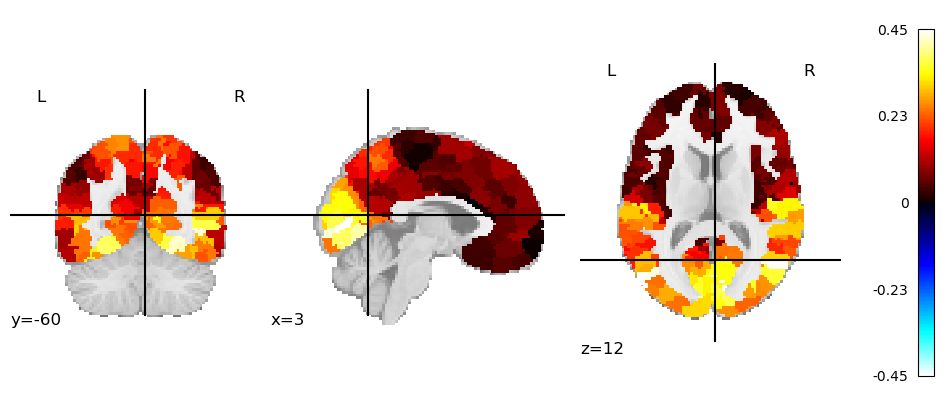

In [218]:
from nilearn import plotting
f, ax = plt.subplots(1,1, figsize = (12, 5))
plotting.plot_stat_map(
    isc_nii, 
    axes=ax
)
plt.show()

In [211]:
data_path

'/Volumes/BCI/Ambivalent_Affect/RishabISC/ISC/data/onesmallstep'

In [213]:
nib.save(isc_nii, f"{data_path}/mean_isc_1000parcels")